In [2]:
from pathlib import Path
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
#nltk.download('stopwords')
stoplist = stopwords.words('english')

# MPL block
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)
import os
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA


## The LetterBoxd Corpus

Letterboxd is a social media where users log and review movies. It happens to be one of the social medias that I use more heavily, so I was interested in making a corpus out of user reviews in order to see what data can be acquired from anonymous movie opinions.

I was lucky enough to find an existing github repository made 4 years ago that seemed to scrape letterboxd on a linux machine. It already had functionality to find every valid URL page of reviews for a given user and write lines of text to .json; I just needed to change the html parsing to work for me.

Here are excerpts of my code from movies.py , where the letterboxd scraping is done. I've commented it all out because it's just meant to be viewed, not ran here.


In [ ]:
#there's code up here that i did not write
#it takes arguments for specific user/whether to write json
#it grabs the valuable parts of html 
#it can be viewed fully in the movies.py file
"""
#grab titles from html

        titles = []
        reviews = []
        for line in smallStr.splitlines():
            soup = BeautifulSoup(line, 'html.parser')
            div_tags = soup.find_all('div')
            for div_tag in div_tags:
                title = div_tag.get('data-film-slug')
                if title is not None:
                    titles.append(title)

#this function gets rid of weird unicode stuff and extra garbage

def clean(string):
    string = string.replace('\n', ' ').replace('\\', ' ').replace('’', '\'')
    string = string.replace('“', '\"').replace('”', '\"').replace("…", "...")
    string = string.replace('This review may contain spoilers. I can handle the truth.', ' ')
    return string
"""

In [ ]:
"""
#save the rating out of ten given by the user
#then discard more html

            ratingIndex = line.find('-green rated-')
            chopped0 = line[ratingIndex:]
            rating = ""
            if ratingIndex != -1:
                rating = chopped0[13:15] + "/10"
                rating = rating.replace("\"", "")
            reviewStart = line.find('-prose')
"""

In [ ]:
"""
#grab reviews    

            if reviewStart != -1:
                chopped = line[reviewStart:]
                soup = BeautifulSoup(chopped, 'html.parser')
                paragraphs = [p.get_text() for p in soup.find_all('p')]
                paragraphs = [s + " " for s in paragraphs]
                #rprint(paragraphs)
                reviewStr = "\n".join(paragraphs)
                reviewStr = rating + " " + reviewStr
                reviews.append(clean(reviewStr))
"""

In [ ]:
"""
#if a review contains a weird unicode elipses, we have to visit its individual URL to grab the full thing

        for i in range (len(titles)):
            #if review contains weird ...
            if "…" in reviews[i]:
                reviewsText[titles[i]] = getSingleReview(url=f'https://letterboxd.com/{user}/film/{titles[i]}/')
            #if review fits in the preview
            else:
                reviewsText[titles[i]] = reviews[i]
                
def getSingleReview(url=''):
    for possibleUrl in (url, url + '/1/'):  # super-8 review had a an extra /1/ on the end
        soup = BeautifulSoup(requests.get(possibleUrl).text, 'html.parser')
        reviewDivHtmlStr = str(soup.find("div", {'class': "review body-text -prose -hero -loose"}))
        sleep(.05)
        if not reviewDivHtmlStr == 'None':
            my_string = '<p>' + reviewDivHtmlStr.split('<div><p>')[-1].replace('</div>', '')
            my_string = re.sub(r'<(\/?p|br).*?>', ' ', my_string)
            return clean(my_string)
"""
#-----------------------------------------------------------------------------------------------------------------
#movies.py goes on to use more code that i did not write to create a .json file containing all the reviews scraped
#-----------------------------------------------------------------------------------------------------------------

So I started grabbing reviews from the most popular users on letterboxd, as well as myself, and storing the .jsons in the letterboxdCorpus folder. I stopped after 16 popular users, who altogether have written 25,000+ reviews. Time to convert all the files into a single .csv

In [ ]:
#this code turns it all into a .csv
"""
directory = "C:\\Users\Connor\Desktop\\370\letterboxdCorpus"

dfs = []
for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                userDf = pd.DataFrame.from_dict(data)
                dfs.append(userDf)
df = pd.concat(dfs, ignore_index=False)
print(df)
df.to_csv("C:/Users/Connor/Desktop/letterboxd/letterboxdCorpus/all.csv")
"""

here's a preview of the csv. it's very fun to look at and sort in google sheets

In [3]:
df = pd.read_csv('C:\\Users\Connor\Desktop\\370\letterboxdCorpus\\all.csv')
df.head()

,movie,user,reviews
0,100-girls,24framesofnick,1/10 I highly recommend everyone get drunk wit...
1,12-rounds,24framesofnick,1/10 My introduction to John cena's absolutely...
2,2-fast-2-furious,24framesofnick,5/10 Not fast enough!
3,21-jump-street,24framesofnick,10/10 On march 24th 2023 Kanye West said he is...
4,80-for-brady,24framesofnick,4/10 Why are old people having fun they're lit...


In [4]:
df.shape

(25344, 3)

## Document Term Matrix

In [30]:
import pandas as pd
#first, a list of reviews without the prepended scores
reviews = df.reviews.tolist()
scoreless = []
for review in reviews:
    scoreless.append(review[5:])
print(scoreless[0:5])
print(len(scoreless))

['I highly recommend everyone get drunk with friends and watch this     ', "My introduction to John cena's absolutely delicious looking biceps     ", 'Not fast enough!     ', ' On march 24th 2023 Kanye West said he is no longer anti semitic because of this movie and Jonah Hill     ', "Why are old people having fun they're literally gonna die tomorrow 😭     "]
25344


I really need to make smaller dataframes first, because the big ones keep crashing my software. So let's see a min_df of 2000 out of 25000 reviews.

In [34]:
vectorizer = CountVectorizer(min_df=2000, lowercase = True, stop_words = 'english')
X = vectorizer.fit_transform(scoreless)
df2 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df2

,film,just,like,movie
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,1
4,0,0,0,0
...,...,...,...,...
25339,0,1,0,1
25340,0,0,0,0
25341,0,1,0,1
25342,1,1,0,0


Evidently these are the 4 most common words. Now try 1000 reviews.

In [35]:
vectorizer = CountVectorizer(min_df=1000, lowercase = True, stop_words = 'english')
X = vectorizer.fit_transform(scoreless)
df2 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df2

,best,don,film,good,great,just,know,like,little,love,make,man,movie,movies,people,pretty,really,story,thing,think,time,ve,way
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25339,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
25340,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
25341,0,2,0,1,0,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
25342,0,2,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0


Notice the chopped off contractions like "don't" and "I've". The conclusion to draw here is that these are the words to expect in a given movie review. Now a couple more permutations before the dfs get too big.

In [36]:
vectorizer = CountVectorizer(min_df=500, lowercase = True, stop_words = 'english')
X = vectorizer.fit_transform(scoreless)
df2 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df2

,action,actually,bad,best,better,big,bit,character,characters,cinema,day,did,didn,does,doesn,don,end,episode,feel,feels,film,films,fuck,fucking,fun,...,probably,quite,real,really,review,right,say,scene,seen,shot,story,sure,thing,things,think,time,ve,want,watch,watching,way,work,world,year,years
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25339,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
25340,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25342,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0


In [37]:
vectorizer = CountVectorizer(min_df=250, lowercase = True, stop_words = 'english')
X = vectorizer.fit_transform(scoreless)
df2 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df2

,100,absolutely,act,action,actually,alongside,american,art,away,bad,basically,beautiful,believe,best,better,big,bit,black,camera,cast,character,characters,cinema,com,come,...,ve,version,violence,violent,want,war,wasn,watch,watched,watching,way,weird,white,wish,woman,women,work,works,world,worst,wrong,yeah,year,years,young
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25339,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0
25340,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25342,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


As to be expected, we have common words to describe movies and all of the fun-to-use swear words.

## Clustering
I am very much lost when it comes to k-means, but this is just me going through the motions.

In [7]:
vectorizer = TfidfVectorizer(lowercase = True,
                             min_df = 10,
                             stop_words='english')
matrix = vectorizer.fit_transform(scoreless)

vocabulary = vectorizer.get_feature_names_out()

matrix.shape

(25344, 7915)

In [12]:
wcss = [] 
for i in range(1, 50): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(matrix) 
    wcss.append(kmeans.inertia_)

C:\Users\Connor\miniconda3\envs\370\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


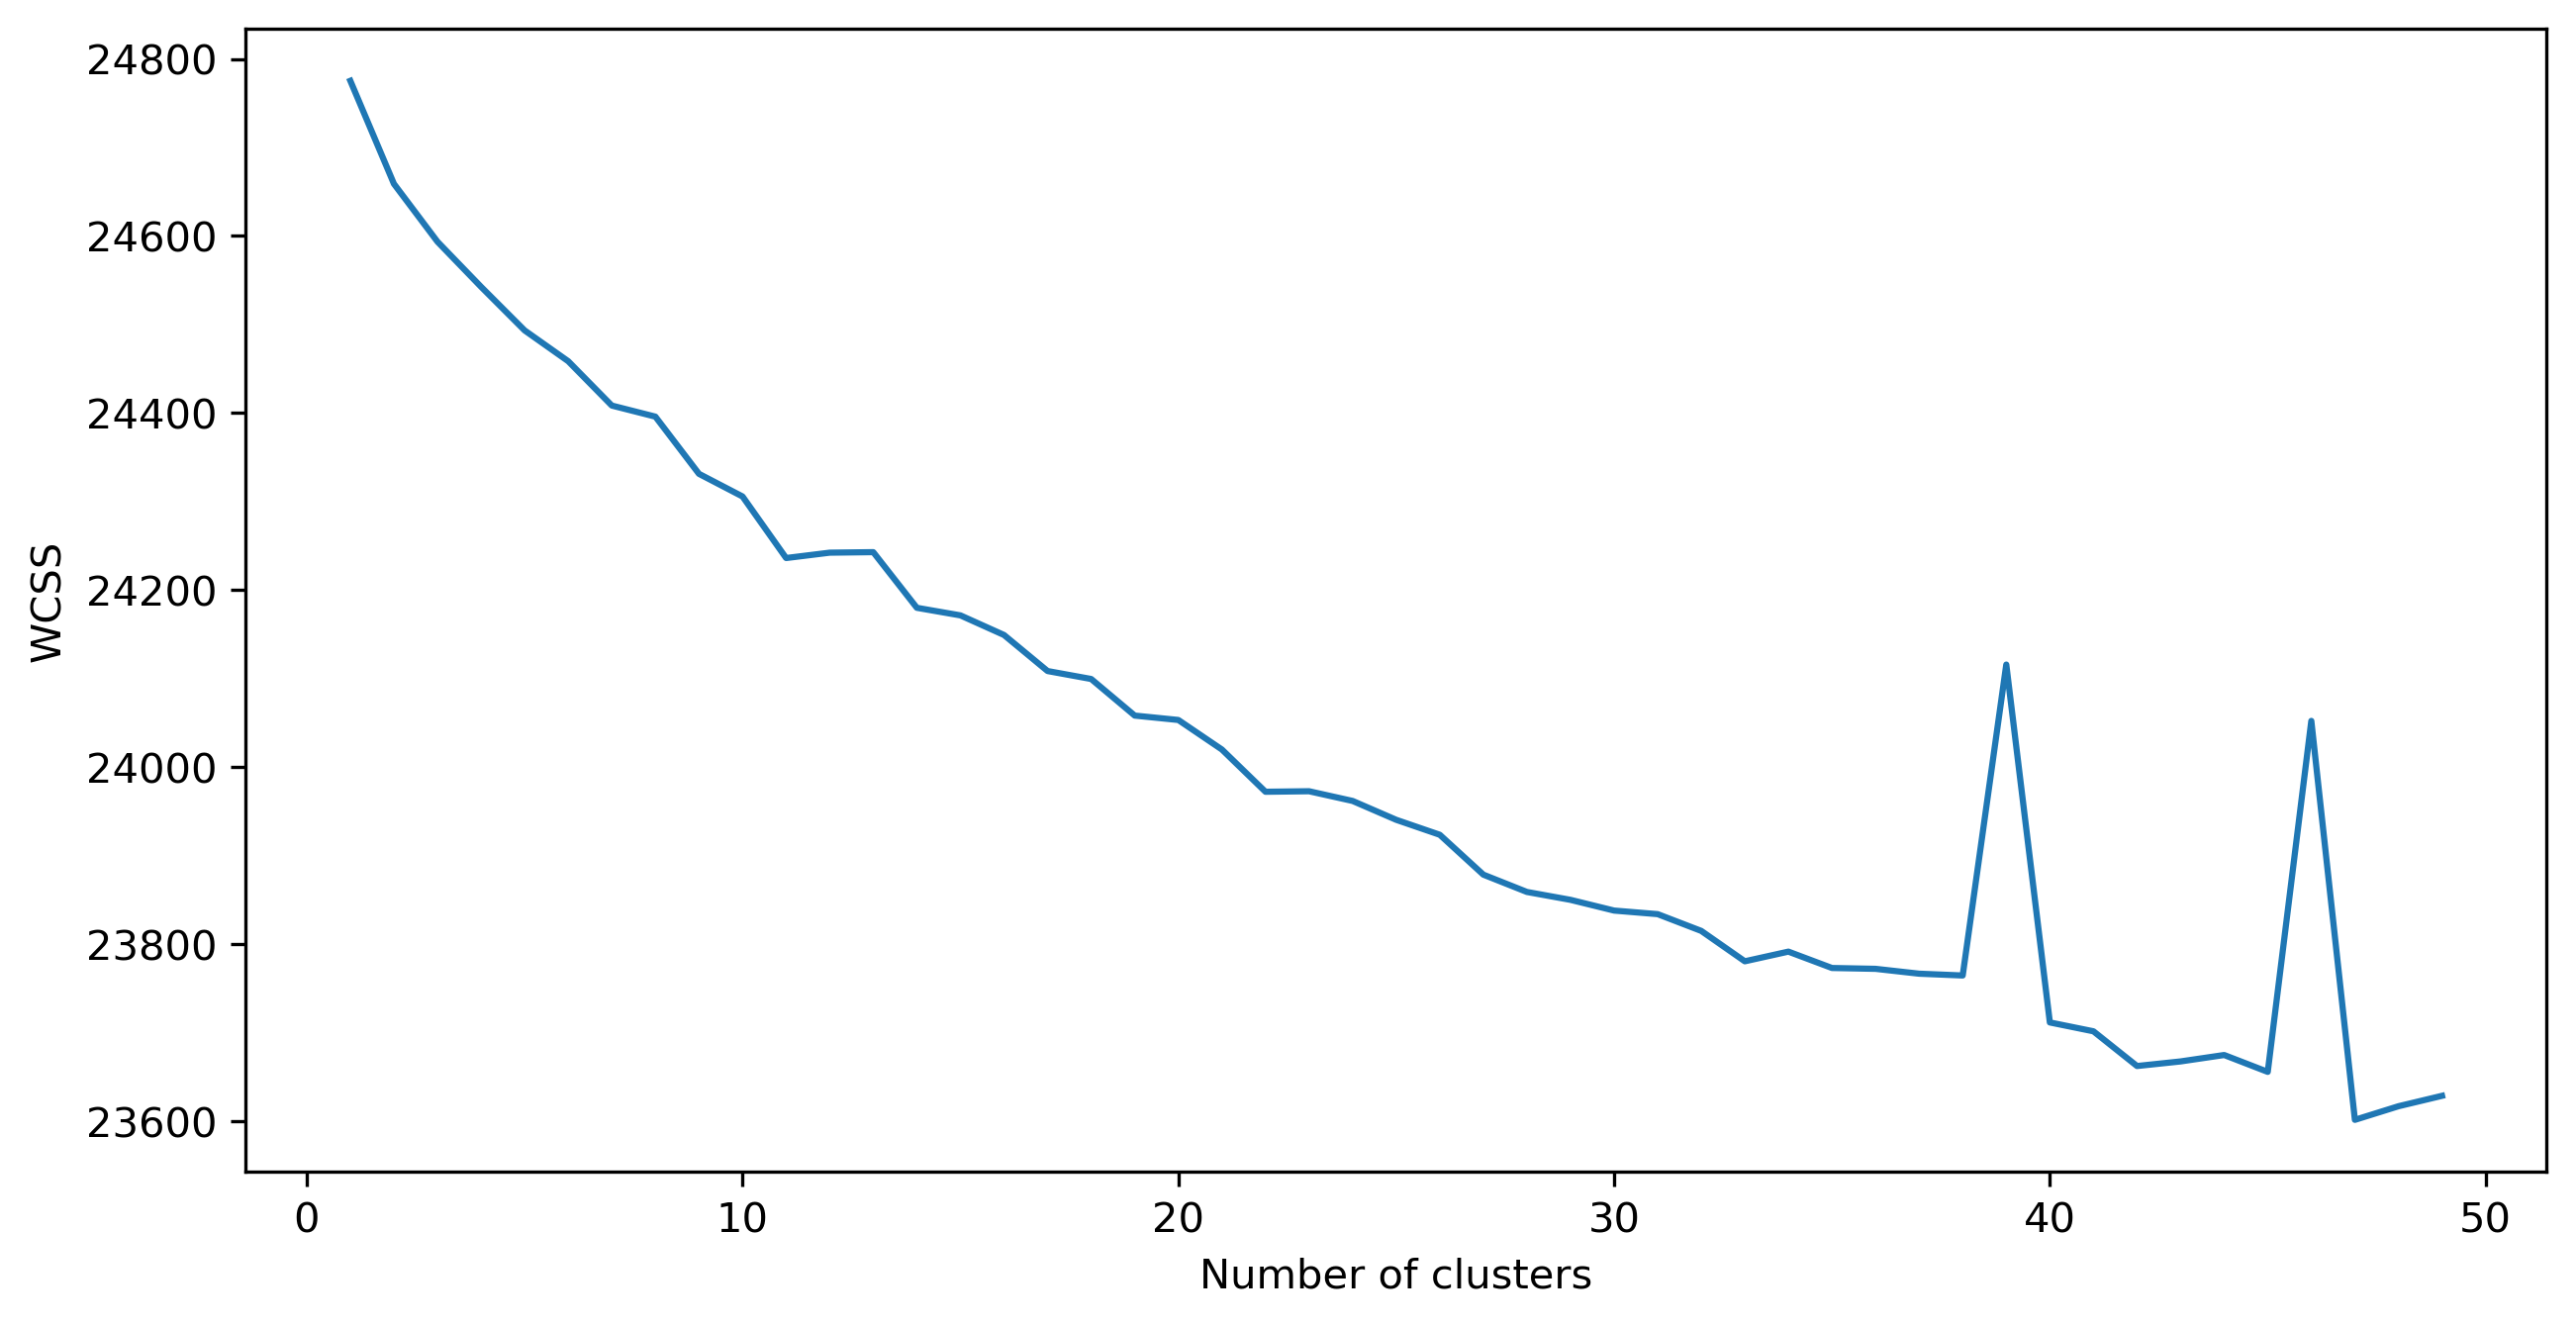

In [14]:
plt.plot(range(1, 50), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

That sure is a graph. I do wonder what it means.

In [15]:

nmf = NMF(n_components=17, 
          random_state=1, 
          max_iter=500, 
          init='nndsvd').fit(matrix)
nmf_W = nmf.transform(matrix)
nmf_H = nmf.components_
nmf_W.shape

(25344, 17)

I had to comment out the float score next to terms because it breaks the function for some reason

In [16]:
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "{:d}: ".format(topic_idx)
        message += " ".join([feature_names[i] + ' ' #+ str(round(topic[i], 2)) + ','
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

NMF topics! A disappointing amount of people's words are used to plug their podcasts or patreons or whatever. But I do appreciate the frequency of swear words.

In [17]:
display_topics(nmf, vocabulary, 10)

0: way  pretty  movies  little  man  people  make  real  thing  life 
1: episode  bonus  listen  free  podcast  sleazoids  eps  access  talked  patreon 
2: movie  best  perfect  great  fun  watch  make  year  bad  christmas 
3: good  pretty  bad  actually  yeah  movies  guys  thing  cinema  feel 
4: review  screencrush  com  tiff  digging  grateful  ol  rating  guys  helps 
5: love  movies  women  cinema  fucking  story  beautiful  life  fall  things 
6: fuck  fucking  shit  holy  oh  god  man  gay  ass  yeah 
7: like  feel  feels  looks  look  doing  felt  sounds  shit  lot 
8: don  know  want  say  look  make  people  talk  shit  feel 
9: ve  seen  best  got  watched  films  times  worst  haven  movies 
10: just  watch  guy  gonna  let  say  maybe  literally  isn  yeah 
11: killing  discussed  suspense  episode  bad  discussion  thriller  podcast  sleazoids  stupid 
12: really  didn  liked  huh  great  say  sure  wanted  fun  lot 
13: film  best  beautiful  year  perfect  watch  horr

In [18]:
cv = CountVectorizer(lowercase = True,
                     min_df = 10,
                     stop_words='english')

X = cv.fit_transform(scoreless)

lda_vocab = cv.get_feature_names_out()

X.shape

(25344, 7915)

To be honest, most of these words are ones I'd expect from internet movie reviews. It's cool that you can sometimes tell what movie the review is about from such a minimal display.

In [19]:
lda = LDA(n_components=17).fit(matrix)
display_topics(lda, lda_vocab, 10)

0: killing  discussed  suspense  episode  cinema  like  gay  got  movie  tim 
1: good  movie  like  just  ll  needs  think  ve  title  hot 
2: movie  academy  like  jake  award  serve  star  happens  time  gyllenhaal 
3: movie  want  perfect  watch  ok  ah  com  genius  dog  twitter 
4: terrifying  better  like  lol  ate  movie  ugh  broke  thanks  bong 
5: like  movie  film  just  time  good  really  pretty  little  best 
6: embargoat  sucks  club  words  gonna  denis  movie  just  girls  gotta 
7: episode  podcast  sleazoids  listen  bonus  free  talked  alongside  eps  itunes 
8: like  film  movie  just  horror  way  really  story  pretty  action 
9: cute  movie  loved  like  watched  favourite  really  don  wanna  just 
10: like  movie  okay  sad  just  don  know  film  tom  make 
11: review  screencrush  com  crying  wow  bad  fucking  movie  good  vibes 
12: did  nice  don  need  love  just  little  like  women  great 
13: fuck  oh  shit  movie  masterpiece  sure  fucked  holy  l

## Collocations Findings

First, make a big string of all the reviews.

In [20]:
#big string
string = ""
reviews = df.reviews.tolist()
for review in reviews:
    string += review[5:] + " "
#this one takes a while

In [21]:
def lemmify(a_string):
    """
    processed takes a string and returns a list of lemmas
    Requires the following imports:
    -------------------------------
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer() 
    """
    # Get rid of HTML (or HTML-like) tags
    clean = re.sub('<.*?>', '', a_string)
    # first we lower-case everything
    lowered = clean.lower()
    # then tokenize
    tokens = word_tokenize(lowered)
    # remove stopwords
    words = [token for token in tokens if token not in stoplist]
    # lemmatize
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    # Return a list of lemmas
    return lemmas

Again, more evidence of shamless podcast plugs. And then some common phrases. If you ctrl+f "podcast sleazoids" in the csv some guy mentions it over 400 times.

In [22]:
tokens = lemmify(string)

corpus = nltk.Text(tokens)

corpus.collocations()


podcast sleazoids; full review; bonus eps; review screencrush; feel
like; talked full; full alongside; itunes spotify; latest patron-
exclusive; 've seen; full discussion; suspense killing; subscribing
patreon; every single; gain access; kfbr392 kfbr392; ever seen; free
episode; covered far; 've ever


Here's an idea of what the average letterboxd review is. It may be chance, but this particular instance has a fair bit of negative/critical words. 

In [24]:
corpus.generate()

hard ( expensive ! ) ( nother ) disposable netflix thriller fails
anything potentially clever premise — pharmaceutical company basically
contrives , along helpless yet eventually complicit military , stage
fight kong godzilla boost tv rating network sponsor . `` know rule !
'' solitude hideous urban architecture edward hopper roaring engine
bullitt . essay , will- 's fine . '' eight crazy night '' took class
warfare . , full amusing character , 's 16 minute long gave lupin
bigger role movie ca . comedic drama two different movie year ( aside
intermittent appreciation brian eno got `` 24


"hard ( expensive ! ) ( nother ) disposable netflix thriller fails\nanything potentially clever premise — pharmaceutical company basically\ncontrives , along helpless yet eventually complicit military , stage\nfight kong godzilla boost tv rating network sponsor . `` know rule !\n'' solitude hideous urban architecture edward hopper roaring engine\nbullitt . essay , will- 's fine . '' eight crazy night '' took class\nwarfare . , full amusing character , 's 16 minute long gave lupin\nbigger role movie ca . comedic drama two different movie year ( aside\nintermittent appreciation brian eno got `` 24"